In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import covasim_aus_schools as cvv
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import kalepy
import sciris as sc
from tqdm.notebook import tqdm
import functools
import covasim.utils as cvu
from statsmodels.stats.proportion import proportion_confint
import shutil

plt.rcParams["svg.fonttype"] = "none"
import datetime as dt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 120  # Increase resolution inside notebook itself
import scipy.stats as stats
import scipy

days = lambda x: dt.timedelta(days=x)
import covasim.misc as cvm
import covasim.plotting as cvpl


Covasim 3.0.7 (2021-06-29) — © 2021 by IDM


In [3]:
results = cvv.Dataset("school_final_results", preload=False)

In [4]:
results

<Dataset:
	'n_incursions':[1, 2, 3]
	'incursion_layer':['high_school', 'primary_school']
	'tracing_algorithm':['class_quarantine', 'class_quarantine+test_to_stay', 'class_test_to_stay', 'no_tracing', 'school_test_to_stay']
	'npis':[0, 0.25, 0.5]
	'vaccine_coverage':['0_0_0_80_100', '0_60_60_80_100', '0_80_80_80_100', '0_80_80_80_60', '0_80_80_80_80', '60_80_80_80_100', '80_80_80_80_100']
	'surveillance':['none', 'students', 'teachers']
	'tts_compliance':[0, 0.25, 0.5, 0.75, 1]
	'cross_classroom':['base', 'double', 'max']
	'symp_prob':[0.06, 0.11, 0.16]
	'screening_frequency':[1, 2, 3, 7]
>

In [5]:
tracing_desc = {
"no_tracing":"No contact tracing for schools",
"class_quarantine":"Class contacts quarantine",
"class_test_to_stay":"Class contacts test-to-stay",
"close_quarantine":"Close contacts quarantine",
"close_test_to_stay":"Close contacts test-to-stay",
"class_quarantine+test_to_stay": "Class contacts quarantine + test at home",
"test_class+school_one_off":"Class contacts test-to-stay + school one-off",
"school_test_to_stay":"Entire school test-to-stay",
"unvaccinated_quarantine":"Quarantine only unvaccinated close contacts",
"unvac_quar_test_to_stay":"Quarantine unvaccinated + close contact test-to-stay",
}

screening_desc = {
    'none':"No screening",
    'students':"Twice weekly student screening",
    'teachers':'Twice weekly teacher screening',
}

# Trajectories

- Summary figures showing the overall timecourse of the outbreak

## Spaghetti plot

In [6]:
results.filter()

<Dataset:
	'n_incursions':[1, 2, 3]
	'incursion_layer':['high_school', 'primary_school']
	'tracing_algorithm':['class_quarantine', 'class_quarantine+test_to_stay', 'class_test_to_stay', 'no_tracing', 'school_test_to_stay']
	'npis':[0, 0.25, 0.5]
	'vaccine_coverage':['0_0_0_80_100', '0_60_60_80_100', '0_80_80_80_100', '0_80_80_80_60', '0_80_80_80_80', '60_80_80_80_100', '80_80_80_80_100']
	'surveillance':['none', 'students', 'teachers']
	'tts_compliance':[0, 0.25, 0.5, 0.75, 1]
	'cross_classroom':['base', 'double', 'max']
	'symp_prob':[0.06, 0.11, 0.16]
	'screening_frequency':[1, 2, 3, 7]
>

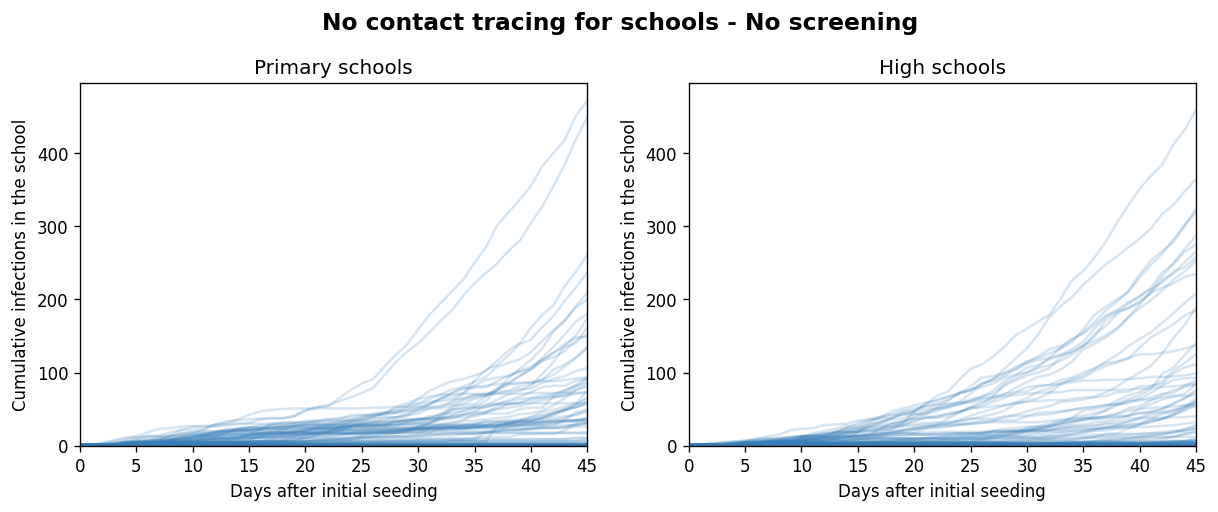

In [7]:
res_primary = results.get(
	n_incursions = 1,
	incursion_layer = 'primary_school',
	tracing_algorithm = 'no_tracing',
	npis = 0,
	vaccine_coverage = '0_80_80_80_100',
	surveillance = 'none',
	tts_compliance = 1,
	cross_classroom = 'base',
    symp_prob=0.11,
    screening_frequency=2,
)
res_high = results.get(
	n_incursions = 1,
	incursion_layer = 'high_school',
	tracing_algorithm = 'no_tracing',
	npis = 0,
	vaccine_coverage = '0_80_80_80_100',
	surveillance = 'none',
	tts_compliance = 1,
	cross_classroom = 'base',
    symp_prob=0.11,
    screening_frequency=2,
)

colors = sc.gridcolors(1)

fig, ax = plt.subplots(1,2)
for i in range(0, 100):
    summary, df = res_primary.get(i)
    ax[0].plot(df.index, df['cum_school_infections'],color=colors[0], alpha=0.2)

    summary, df = res_high.get(i)
    ax[1].plot(df.index, df['cum_school_infections'],color=colors[0], alpha=0.2)

ax[0].set_title('Primary schools')
ax[1].set_title('High schools')

ax[0].set_ylim(0, max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]))
ax[1].set_ylim(ax[0].get_ylim())

ax[0].set_xlim(0,45)
ax[1].set_xlim(0,45)


ax[0].set_xlabel('Days after initial seeding')
ax[1].set_xlabel('Days after initial seeding')

ax[0].set_ylabel('Cumulative infections in the school')
ax[1].set_ylabel('Cumulative infections in the school')

fig.suptitle(f"{tracing_desc[res_high.id['tracing_algorithm']]} - {screening_desc[res_high.id['surveillance']]}", fontsize=14, fontweight='bold',y=1.03)
fig.set_size_inches(12,4)

Path('figures').mkdir(parents=True, exist_ok=True)
cvv.savefig('figures/spaghetti_plot.png')

# Bar plots

In [8]:
def hex2grey_level(hexstr)->float:
    # hexstr:  #5ab3aa
    # returns: 0 is black and 1 is white
    rgb = tuple(int(hexstr[i:i+2], 16) for i in (1, 3, 5))    
    level = (0.3*rgb[0]/255) + (0.59*rgb[1]/255) + (0.11*rgb[2]/255)
    return level

In [9]:
def plot_segments(df, colors, ax, labels=None):
    
    if labels is None:
        labels = df.columns
        
    offset = np.zeros(len(df))
    
    def plot_segment(vals, color, label, xerr=None):
        # vals - a single column from the dataframe to plot
        # color - colors 
        vals = vals.values.ravel()

        h = ax.barh(np.arange(len(vals)), 
              vals,
              color=color,
              xerr=xerr,
              label = label,
              left=offset
             )
                
        for i, (o, v) in enumerate(zip(offset, vals)):
            if v > 0.1:
                if hex2grey_level(color) < 0.7:
                    textcolor = 'white'
                else:
                    textcolor='black'
                ax.text(o+v/2, i, '%0.0f%%' % (100*v), color=textcolor, fontweight='normal', horizontalalignment='center', verticalalignment='center',size=12, weight='bold')
        
        np.add(offset, vals, offset) # Can increment in-place without declaring global by calling np.add instead of using +=

    for col, color, label in zip(df.columns, colors, labels):
        plot_segment(df[col], color, label)             

In [10]:
def range_str(a,b):
    if (b-1) == a:
        return f'{a}'
    elif not np.isfinite(b):
        return f'{a}+'
    else:
        return f'{a}-{b-1}'

In [11]:
def plot_bars(results, label_fcn=None, order=None):
    
    if label_fcn is None:
        label_fcn = lambda res: str(res.identifier)
    
    if not order:
        order = np.arange(len(results))
        
    fig, axes = plt.subplots(1,2)
    
    # PLOT INFECTIONS 
    thresholds = [1,2,7,12,22,52, np.inf]
    vals = {}
    mean = {}
    for res in results:
        x = np.zeros(len(thresholds)-1)
        cols = []
        for i in range(len(thresholds)-1):
            x[i] = (np.count_nonzero((res['cum_school_infections']>=thresholds[i]) & (res['cum_school_infections']<thresholds[i+1])))
            cols.append(range_str(thresholds[i]-1, thresholds[i+1]-1))
        x = x/len(res)

        if label_fcn(res) in vals:
            raise Exception(f'Already seen {res}')
        vals[label_fcn(res)] = x
        mean[label_fcn(res)] = np.average(res['cum_school_infections']-1)

    df = pd.DataFrame.from_dict(vals, orient='index')
    df.columns = cols
    df = df.iloc[order]
    mean = np.array([mean[k] for k in df.index])

    colors = ['#c90000','#ff8080', '#ffe6e6', '#c1e1f1','#2b8cbe','#05ab0b']
    plot_segments(df, colors[::-1], axes[0])
    for i, v in enumerate(mean):
        axes[0].text(1.03, i, '%.0f\ninfections' % (v), color='black', fontweight='normal', horizontalalignment='left', verticalalignment='center',size=12)
    axes[0].text(1.03, -0.5, 'Mean' % (v), color='black', fontweight='bold', horizontalalignment='left', verticalalignment='center',size=12)

    # PLOT DAYS LOST
    thresholds = [0,1,14,50,150,300,np.inf]
    vals = {}
    mean = {}
    for res in results:
        x = np.zeros(len(thresholds)-1)
        cols = []
        for i in range(len(thresholds)-1):
            x[i] = (np.count_nonzero((res['cum_person_days_lost']>=thresholds[i]) & (res['cum_person_days_lost']<thresholds[i+1])))
            cols.append(range_str(thresholds[i], thresholds[i+1]))
        x = x/len(res)
        if label_fcn(res) in vals:
            raise Exception(f'Already seen {res}')
        vals[label_fcn(res)] = x
        mean[label_fcn(res)] = np.average(res['cum_person_days_lost'])


    df = pd.DataFrame.from_dict(vals, orient='index')
    df.columns = cols
    df = df.iloc[order]
    mean = np.array([mean[k] for k in df.index])
        
    # SAME SCHEME
    plot_segments(df, colors[::-1], axes[1])

    # PURPLE SCHEME
#     colors = ['#05ab0b','#a1d99b', '#807dba', '#6a51a3','#54278f','#3f007d'] # Green, then purple
#     plot_segments(df, colors, axes[1])
    
    
    for i, v in enumerate(mean):
        axes[1].text(1.03, i, '%.0f\ndays' % (v), color='black', fontweight='normal', horizontalalignment='left', verticalalignment='center',size=12)
    axes[1].text(1.03, -0.5, 'Mean' % (v), color='black', fontweight='bold', horizontalalignment='left', verticalalignment='center',size=12)

            
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlim(0, 1)
        ax.set_xlabel('Proportion of simulations')

    axes[0].set_yticks(np.arange(len(df)))
    axes[0].set_yticklabels(df.index)
    axes[1].set_yticks([])
    
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()

#     axes[0].legend(bbox_to_anchor=(1.5, 1), title='Number of infections')
#     axes[1].legend(bbox_to_anchor=(1.5, 1), title='Face-to-face\nteaching days lost')

    legend = axes[0].legend(bbox_to_anchor=(0.5,1.05),
                   title='Number of downstream infections',
                   loc='lower center', ncol=len(colors)
                  )
    plt.setp(legend.get_title(),fontsize=13, fontweight='bold')
    
    legend = axes[1].legend(bbox_to_anchor=(0.5,1.05),
                   title='Face-to-face teaching days lost',
                   loc='lower center', ncol=len(colors)
                  )
    plt.setp(legend.get_title(),fontsize=13, fontweight='bold')

#      , bbox_to_anchor=(0.5,1.05), ncol=1, bbox_transform=fig.transFigure, fontsize=10)
    
    
    fig.set_size_inches(15,5)
    fig.tight_layout()
    return fig

## Quarantine vs test-to-stay

- Overall message is that test-to-stay is about as good as quarantine

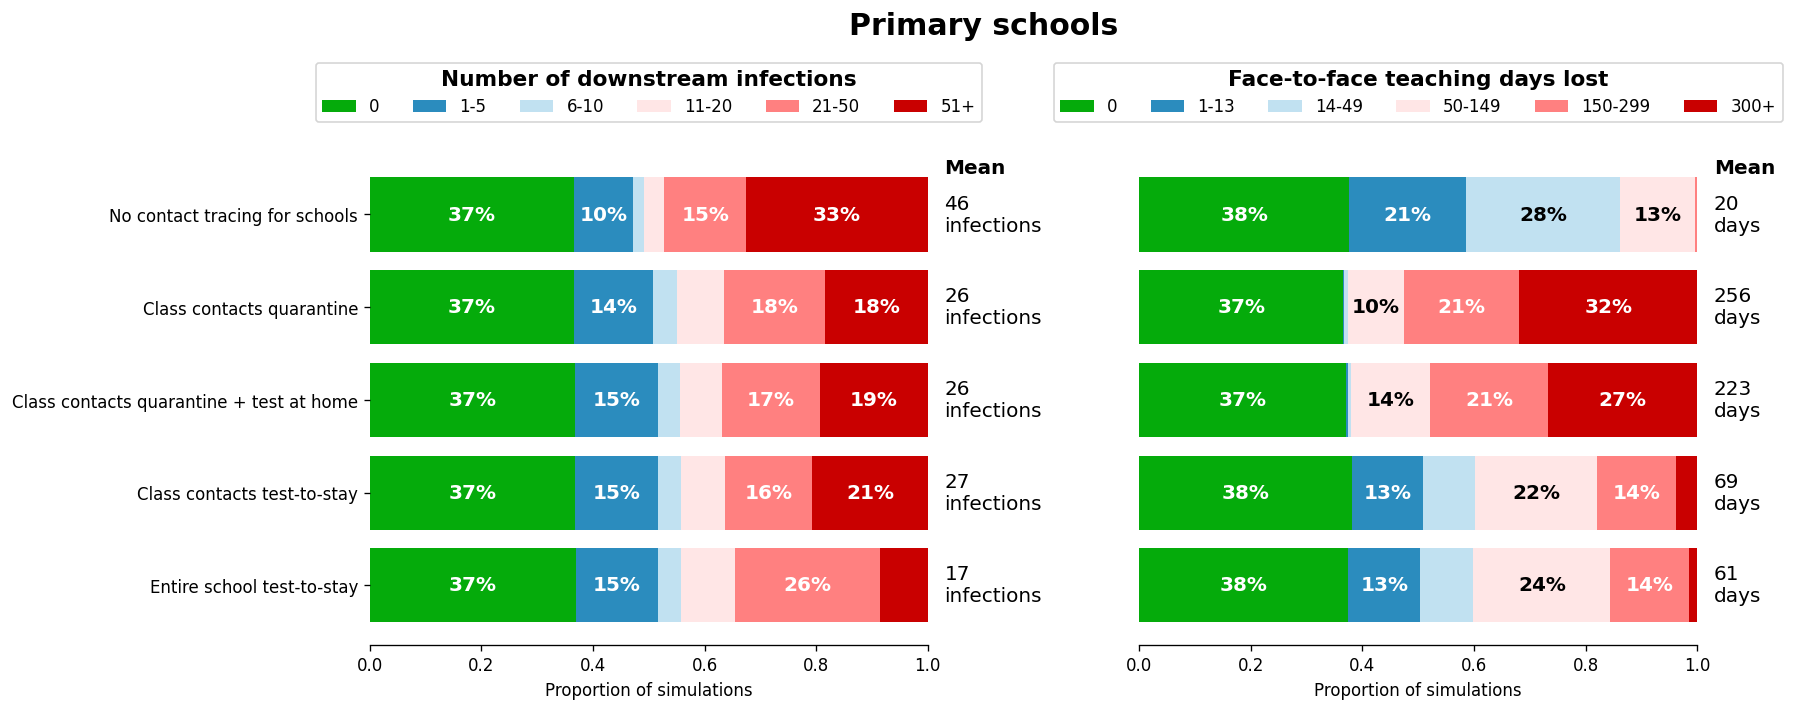

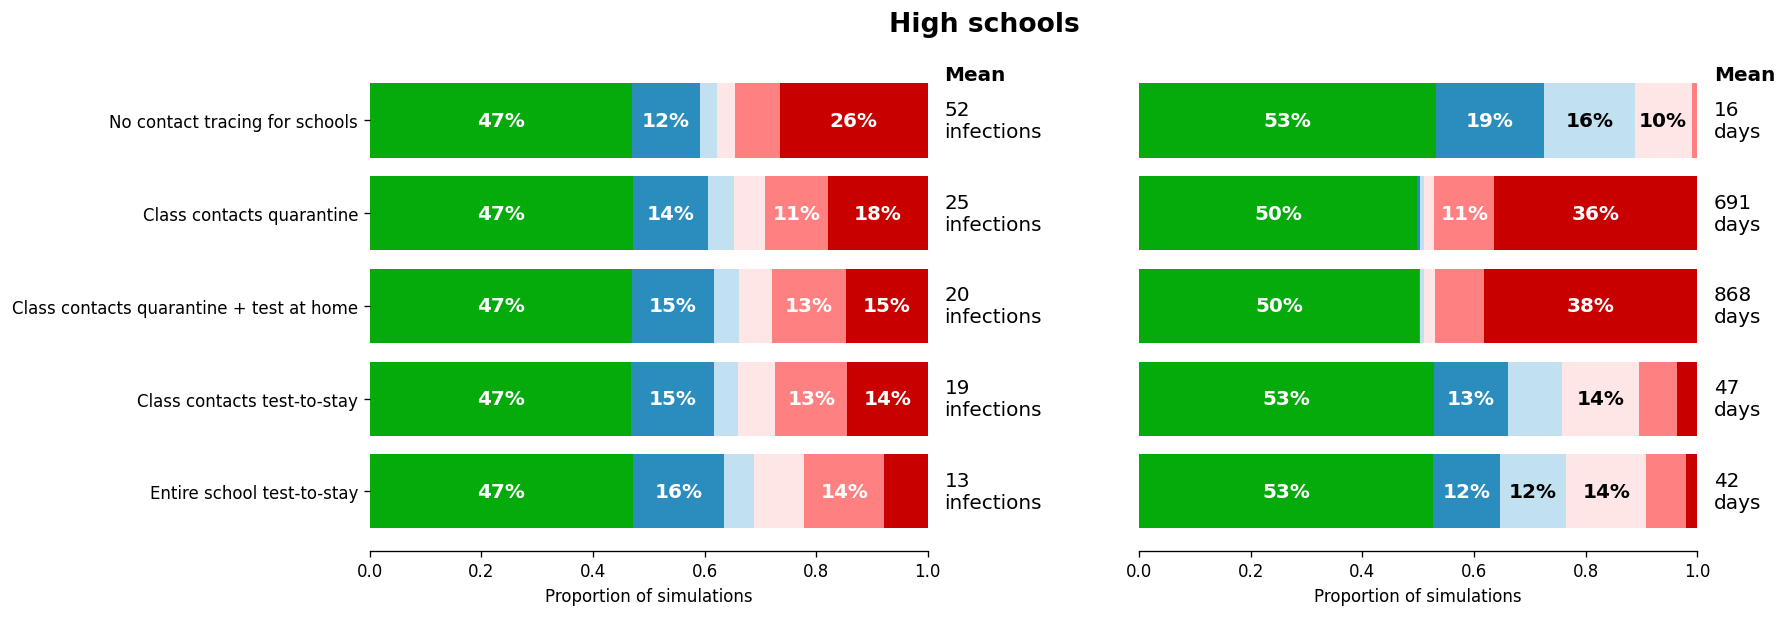

In [12]:
fig = plot_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
#     tracing_algorithm={'no_tracing','class_test_to_stay'},
    surveillance='none',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: tracing_desc[res.id['tracing_algorithm']],
    order = [3,1,0,2,4])
fig.suptitle('Primary schools', fontsize=18, fontweight='bold',x=0.55)
fig.set_size_inches(15,6)

fig.tight_layout()
cvv.savefig('figures/contact_management_ps.png')

fig = plot_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
#     tracing_algorithm={'no_tracing','class_test_to_stay'},
    surveillance='none',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: tracing_desc[res.id['tracing_algorithm']],
    order = [3,1,0,2,4])
fig.suptitle('High schools', fontsize=18, fontweight='bold')
fig.set_size_inches(15,6)

fig.tight_layout()

fig.axes[0].get_legend().remove()
fig.axes[1].get_legend().remove()
fig.suptitle('High schools', fontsize=16, fontweight='bold',y=0.85,x=0.55)

cvv.savefig('figures/contact_management_hs.png')


## Screening benefits

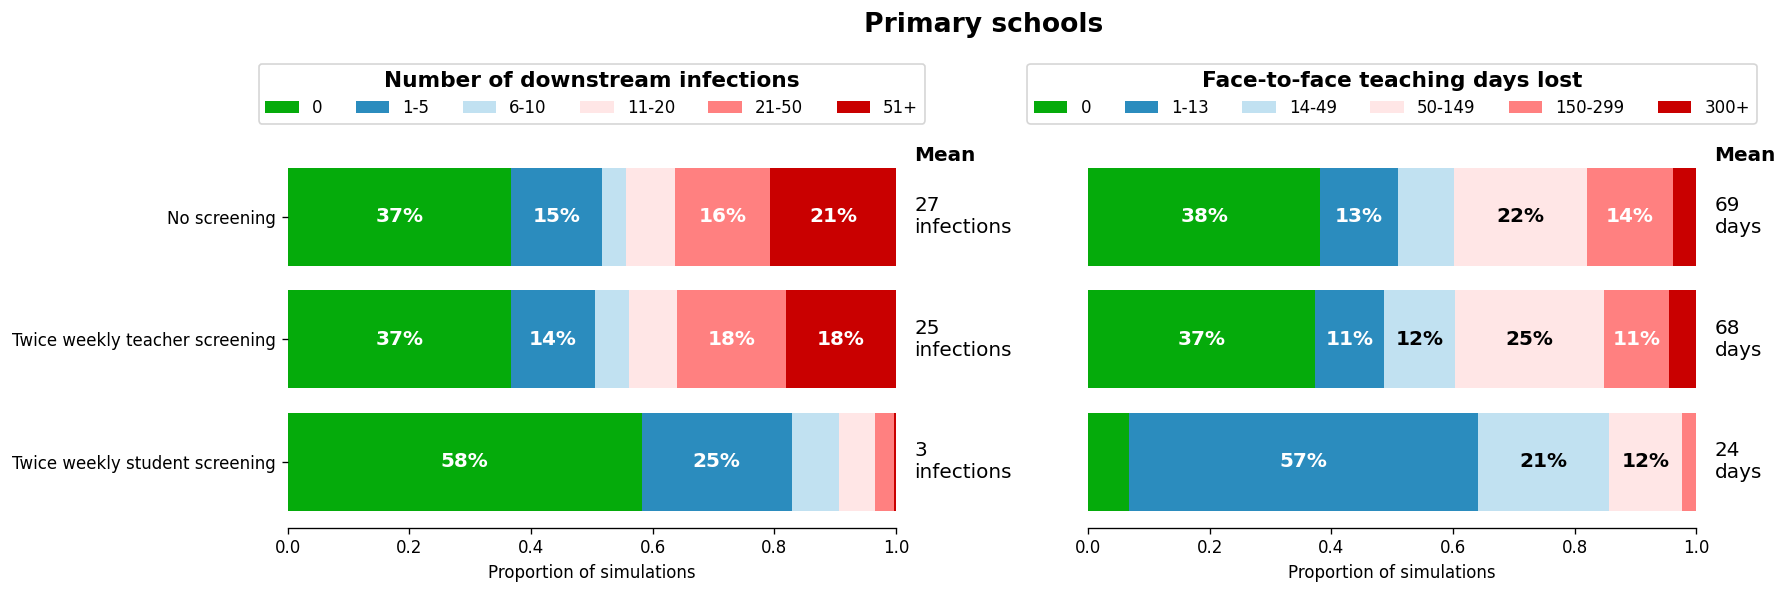

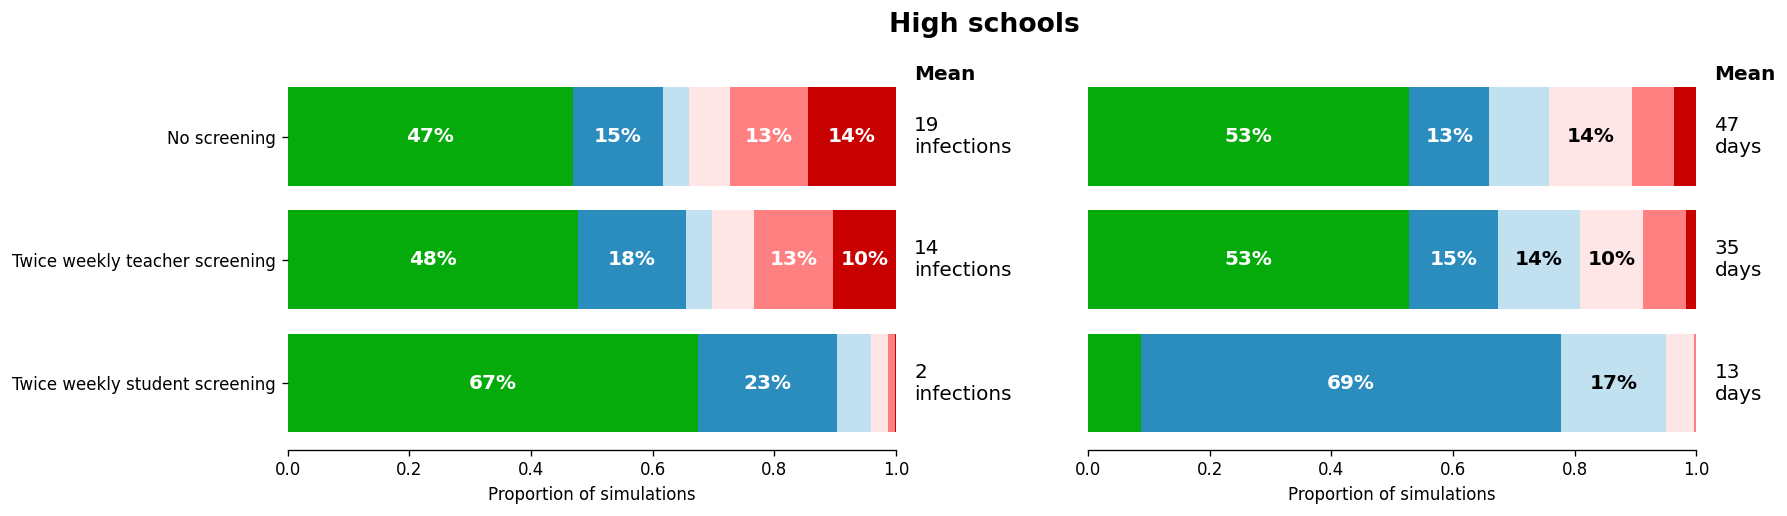

In [13]:
# CLASS TEST-TO-STAY
fig = plot_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: screening_desc[res.id['surveillance']],
    order = [0,2,1])
fig.suptitle('Primary schools', fontsize=16, fontweight='bold', x=0.55)
fig.tight_layout()
cvv.savefig('figures/surveillance_strategies_tts_ps.png')

fig = plot_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: screening_desc[res.id['surveillance']],
    order = [0,2,1])
fig.suptitle('High schools', fontsize=14, fontweight='bold')
fig.tight_layout()

fig.axes[0].get_legend().remove()
fig.axes[1].get_legend().remove()
fig.suptitle('High schools', fontsize=16, fontweight='bold',y=0.85,x=0.55)

cvv.savefig('figures/surveillance_strategies_tts_hs.png')

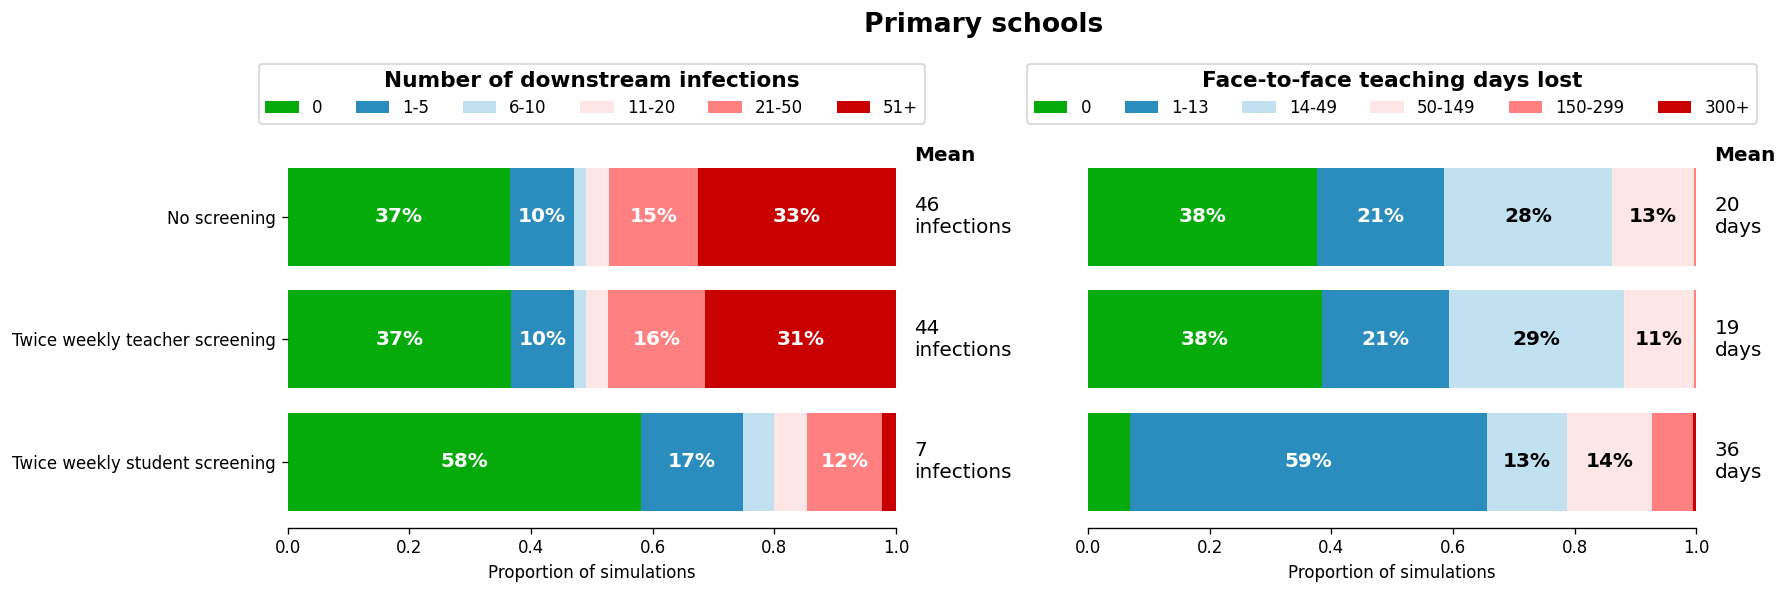

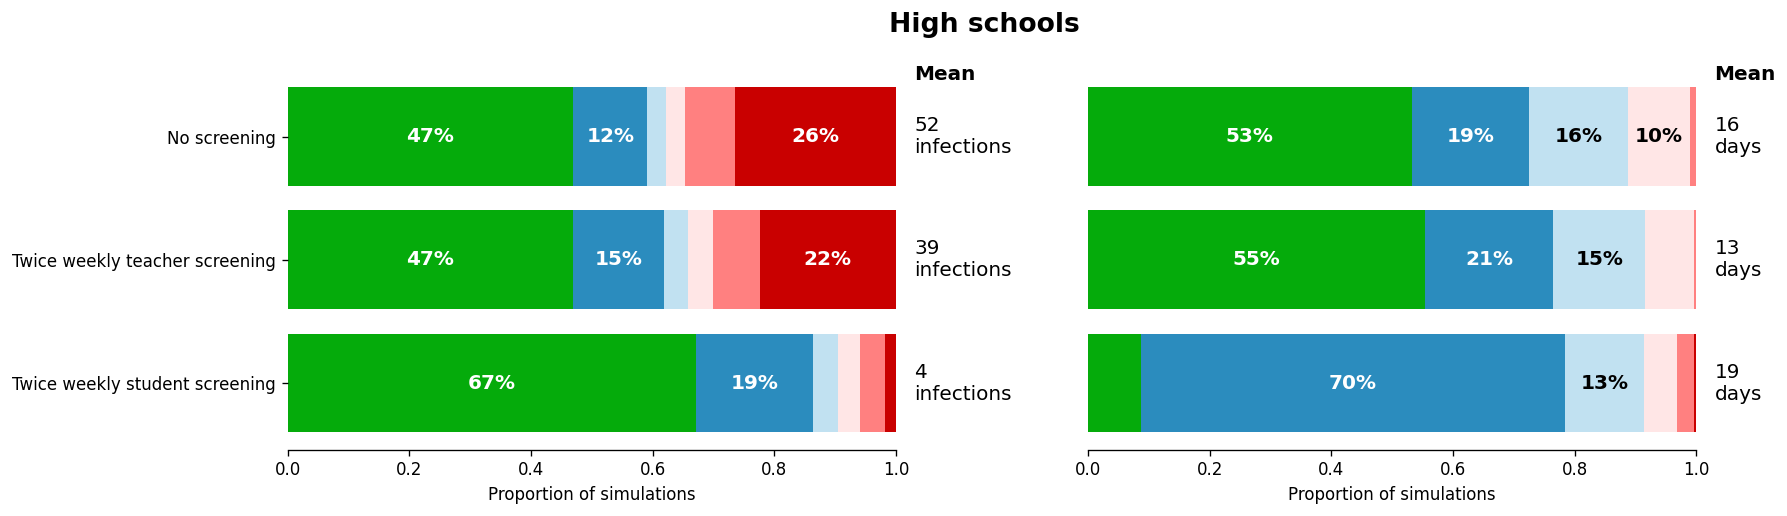

In [14]:
# NO TRACING
fig = plot_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    tracing_algorithm='no_tracing',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: screening_desc[res.id['surveillance']],
    order = [0,2,1])
fig.suptitle('Primary schools', fontsize=16, fontweight='bold',x=0.55)
fig.tight_layout()
cvv.savefig('figures/surveillance_strategies_no_tracing_ps.png')

fig = plot_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    tracing_algorithm='no_tracing',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: screening_desc[res.id['surveillance']],
    order = [0,2,1])
fig.suptitle('High schools', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.axes[0].get_legend().remove()
fig.axes[1].get_legend().remove()
fig.suptitle('High schools', fontsize=16, fontweight='bold',y=0.85,x=0.55)
cvv.savefig('figures/surveillance_strategies_no_tracing_hs.png')

# Sensitivity

These are examples of the sensitivity analyses rendered as bar graphs. These are included as a diagnostic to check against the sensitivity plots in the next section.

## Sensitivity to TTS compliance

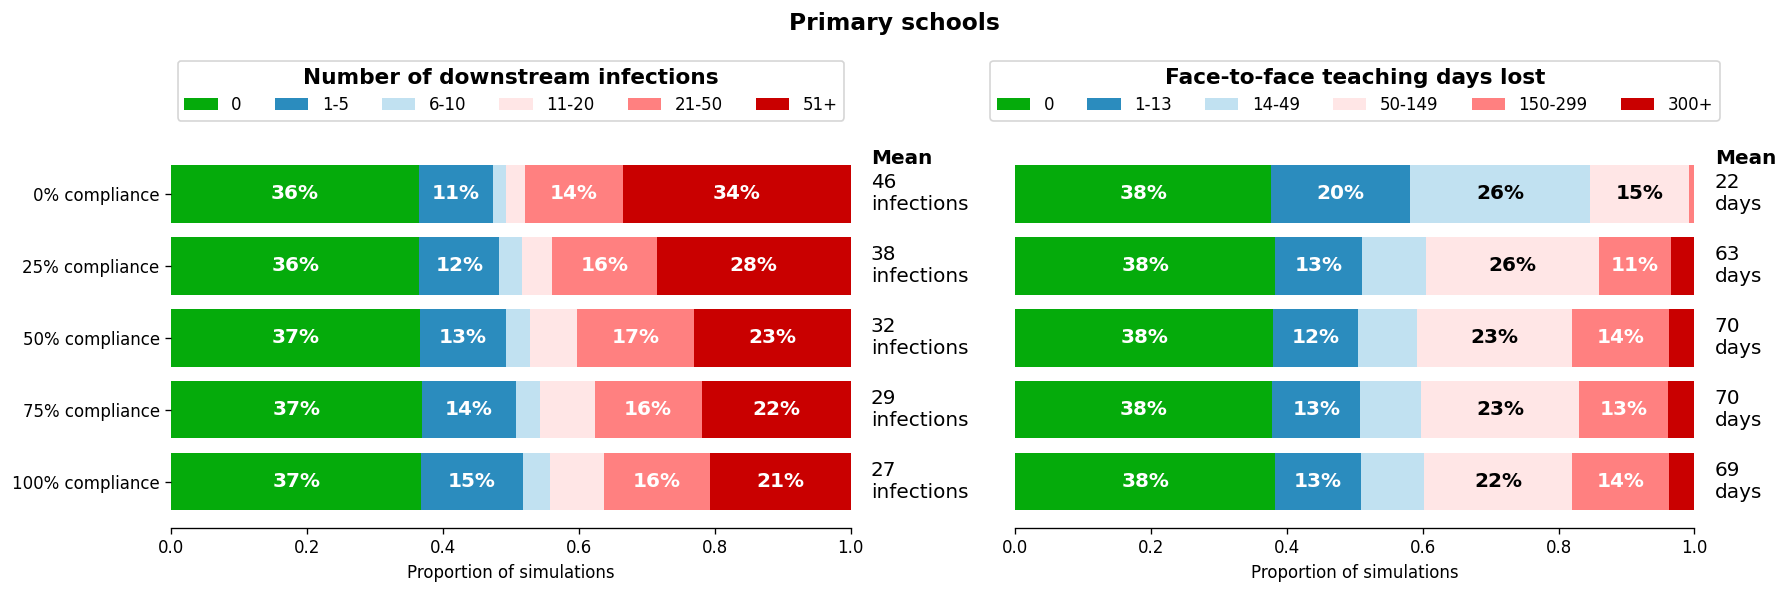

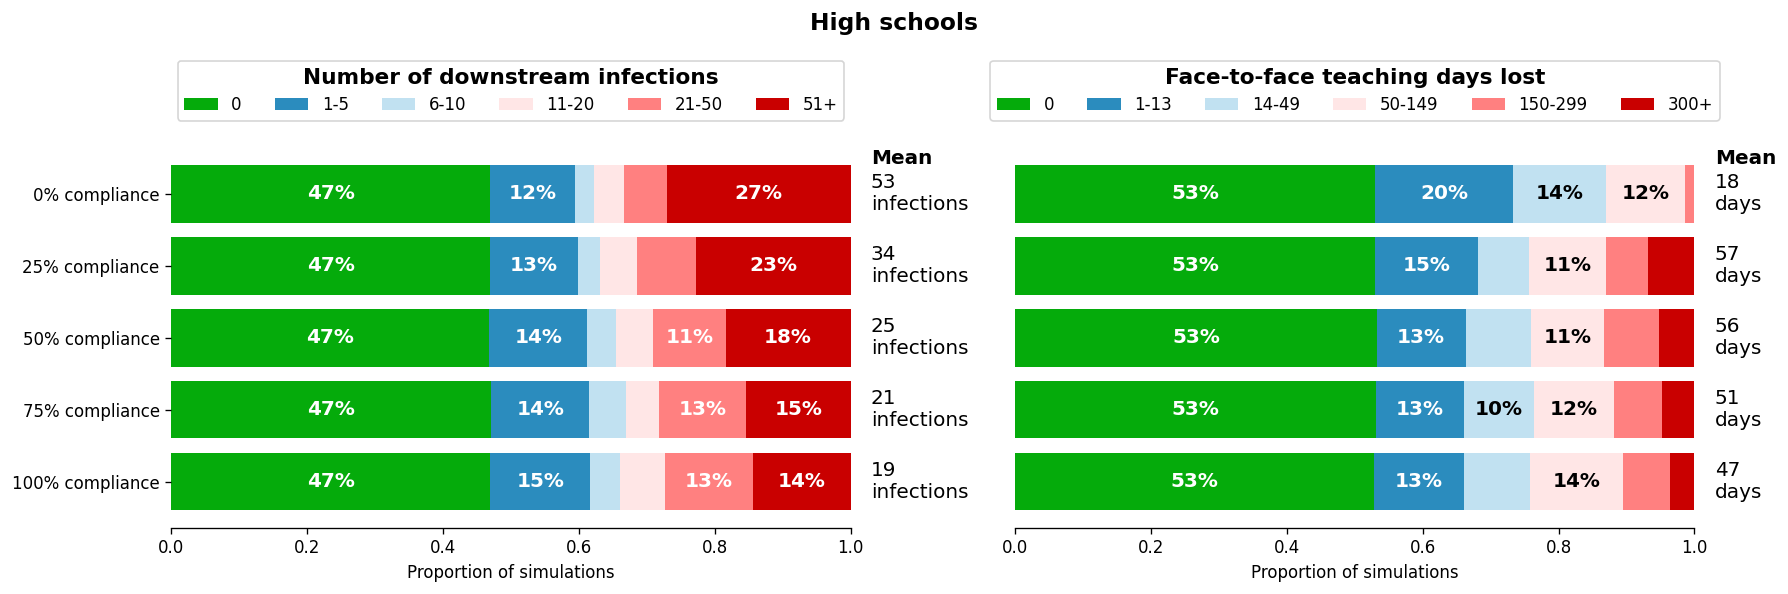

In [15]:
fig = plot_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
#     tts_compliance = 1,
    cross_classroom = 'base',
    tracing_algorithm={'class_test_to_stay'},
    surveillance='none',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f'{100*res.id["tts_compliance"]:.0f}% compliance',
    order = [])
fig.suptitle('Primary schools', fontsize=14, fontweight='bold')
fig.tight_layout()

fig = plot_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
#     tts_compliance = 1,
    cross_classroom = 'base',
    tracing_algorithm={'class_test_to_stay'},
    surveillance='none',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f'{100*res.id["tts_compliance"]:.0f}% compliance',
    order = [])
fig.suptitle('High schools', fontsize=14, fontweight='bold')
fig.tight_layout()


# Dual bar sensitivity

In [16]:
def plot_dual_bars(results, label_fcn, infection_thresholds=(21,51), day_thresholds=(50,100), order=None):

    if not order:
        order = np.arange(len(results))
        
    labels = [label_fcn(res) for res in results]
    labels = [labels[i] for i in order]
    
    fig, ax = plt.subplots(1,2)

    h = {}
    
    ### LEFT SIDE - INFECTIONS
    for infection_threshold, color in zip(infection_thresholds, ['#ff8080','#c90000']):
        mean = np.zeros(len(results))
        low = np.zeros(len(results))
        high = np.zeros(len(results))

        for i, res in enumerate(results):
            mean[i], (low[i], high[i]) = cvv.binomial_ci((res['cum_school_infections']> infection_threshold).values)

        mean = mean[order]
        low = low[order]
        high = high[order]
        
        bar_height = 0.7

        ht = ax[0].barh(np.arange(len(mean)),
                   mean,
#                    xerr=((mean-low),(high-mean)),
                   height=bar_height,color=color,
                  )
        h[infection_threshold] = ht
        
    ax[0].legend(list(h.values()),[f'>{x-1}' for x in h.keys()], loc='upper left')

    #         colors = ['#c90000','#ff8080', '#ffe6e6', '#c1e1f1','#2b8cbe','#05ab0b']

    #     colors = ['#bcbddc','#9e9ac8', '#807dba', '#6a51a3','#54278f','#3f007d'] # All purple
    #     colors = ['#05ab0b','#a1d99b', '#807dba', '#6a51a3','#54278f','#3f007d'] # Green, then purple
    #     plot_segments(df, colors, axes[1])

    ### RIGHT SIDE - DAYS LOST
    
    h = {}

    for day_threshold, color in zip(day_thresholds, ['#999999','#333333']):
        mean = np.zeros(len(results))
        low = np.zeros(len(results))
        high = np.zeros(len(results))

        for i, res in enumerate(results):
            mean[i], (low[i], high[i]) = cvv.binomial_ci((res['cum_person_days_lost']> day_threshold).values)

        mean = mean[order]
        low = low[order]
        high = high[order]

        bar_height = 0.7

        ht = ax[1].barh(np.arange(len(mean)),
                   mean,
#                    xerr=((mean-low),(high-mean)),
                   height=bar_height,color=color,
                  )
        h[day_threshold] = ht

    ax[1].legend(list(h.values()),[f'>{x}' for x in h.keys()], loc='upper right')

#     for y, v in zip(np.arange(len(mean)), mean):
#         if v > 0.1:
#             ax[1].text(v/2, y, '%0.0f%%' % (100*v), color='white', fontweight='normal', horizontalalignment='center', verticalalignment='center',size=12, weight='bold')
#         else:
#             ax[1].text(0.2, y, '%0.0f%%' % (100*v), color='black', fontweight='normal', horizontalalignment='center', verticalalignment='center',size=12, weight='bold')

    ax[0].set_xticks(np.arange(0,1.2,0.2))
    ax[1].set_xticks(np.arange(0.2,1.2,0.2))
    
    ax[0].set_xlim(0,1)
    ax[0].invert_xaxis()

    ax[0].set_yticks(np.arange(len(labels)))
    ax[0].set_yticklabels(labels)
    ax[1].set_yticks([])
    


    ax[1].yaxis.set_visible(False)

    ax[1].set_xlim(0,1)

    ax[0].set_ylim(-0.5,len(labels)-0.5)
    ax[1].set_ylim(-0.5,len(labels)-0.5)
    # ax[1].set_xlim(0,365)
    # ax[0].set_title('Deaths')
    # ax[1].set_title('Restrictions')
    # ax[0].set_xlabel('Number of deaths over 1 year')
    # ax[1].set_xlabel('Average number of days\nunder restrictions')

    fig.set_size_inches(5,3)

    ax[0].set_position([0,0,0.5,1])
    ax[1].set_position([0.5,0,0.5,1])
    
#     ax[2].set_position([0,0,1,1])
#     ax[2].set_xlabel('Proportion of simulations')
    
    
    ax[0].set_title('Number of downstream infections',fontsize=10)
    ax[1].set_title('Face-to-face teaching days lost',fontsize=10)
    
    return fig

## Sensitivity to TTS compliance

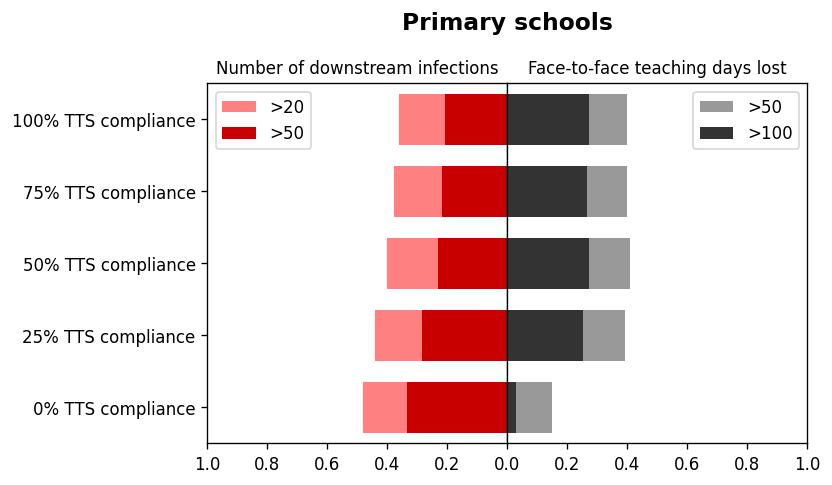

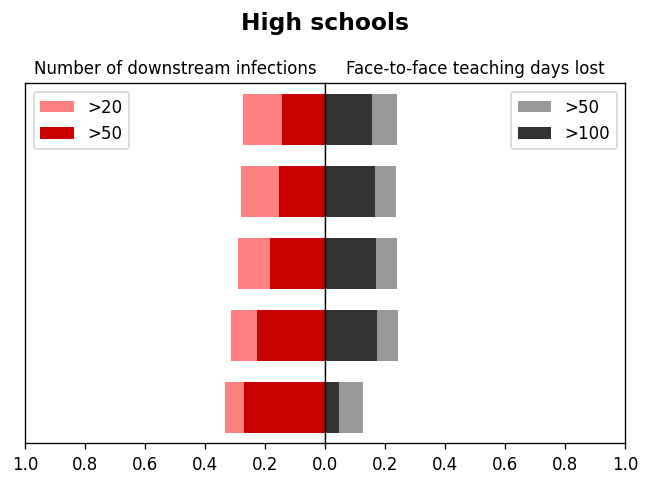

In [17]:
fig = plot_dual_bars(results = results.filter(
    n_incursions = [1],
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
#     tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f'{100*res.id["tts_compliance"]:.0f}% TTS compliance',
    order = [])
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

# fig.axes[0].axhline(1.5, color='k', linewidth=0.75)
# fig.axes[1].axhline(1.5, color='k', linewidth=0.75)
# fig.axes[0].axhline(3.5, color='k', linewidth=0.75)
# fig.axes[1].axhline(3.5, color='k', linewidth=0.75)

cvv.savefig('figures/sensitivity_tts_ps.png')

fig = plot_dual_bars(results = results.filter(
    n_incursions = [1],
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
#     tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f'{100*res.id["tts_compliance"]:.0f}% TTS compliance',
    order = [],
)
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

fig.axes[0].yaxis.set_ticks([])

# fig.axes[0].axhline(1.5, color='k', linewidth=0.75)
# fig.axes[1].axhline(1.5, color='k', linewidth=0.75)
# fig.axes[0].axhline(3.5, color='k', linewidth=0.75)
# fig.axes[1].axhline(3.5, color='k', linewidth=0.75)

cvv.savefig('figures/sensitivity_tts_hs.png')


## Sensitivity to incursions

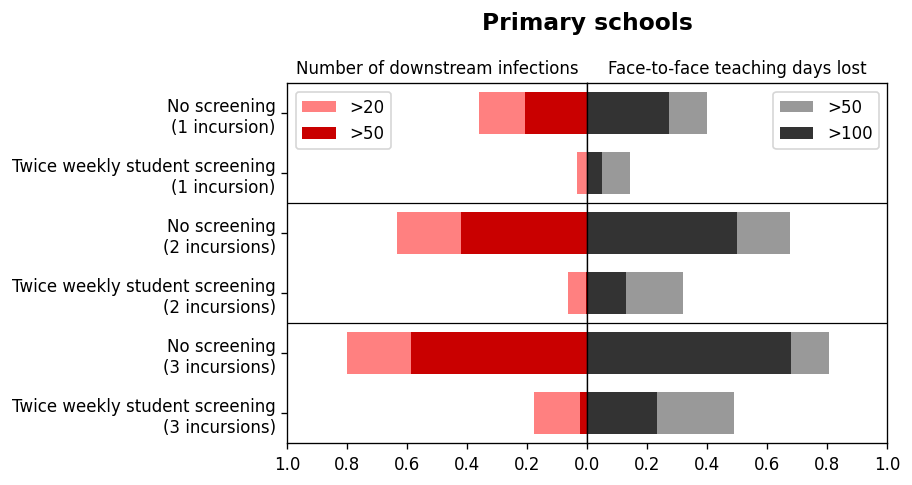

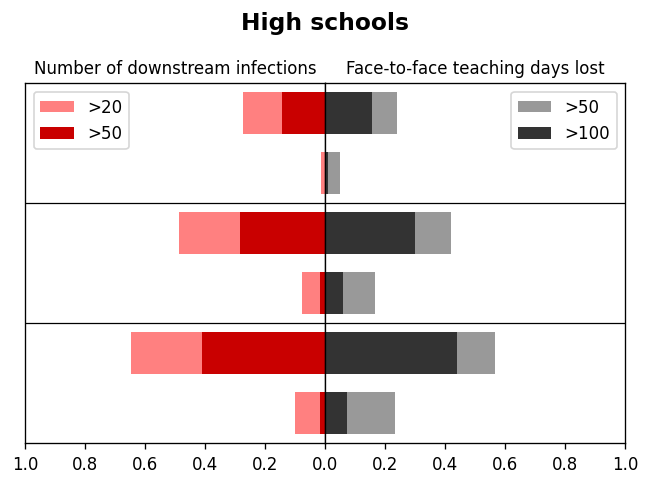

In [18]:
fig = plot_dual_bars(results = results.filter(
    n_incursions = [1,2,3],
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none','students'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: screening_desc[res.id['surveillance']] + f'\n({res.id["n_incursions"]} {"incursions" if res.id["n_incursions"] > 1 else "incursion"})',
    order = [5,4,3,2,1,0])
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

fig.axes[0].axhline(1.5, color='k', linewidth=0.75)
fig.axes[1].axhline(1.5, color='k', linewidth=0.75)
fig.axes[0].axhline(3.5, color='k', linewidth=0.75)
fig.axes[1].axhline(3.5, color='k', linewidth=0.75)

cvv.savefig('figures/sensitivity_incursions_ps.png')


fig = plot_dual_bars(results = results.filter(
    n_incursions = [1,2,3],
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none','students'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: screening_desc[res.id['surveillance']] + f'\n({res.id["n_incursions"]} {"incursions" if res.id["n_incursions"] > 1 else "incursion"})',
    order = [5,4,3,2,1,0],
)
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

fig.axes[0].yaxis.set_ticks([])

fig.axes[0].axhline(1.5, color='k', linewidth=0.75)
fig.axes[1].axhline(1.5, color='k', linewidth=0.75)
fig.axes[0].axhline(3.5, color='k', linewidth=0.75)
fig.axes[1].axhline(3.5, color='k', linewidth=0.75)

cvv.savefig('figures/sensitivity_incursions_hs.png')

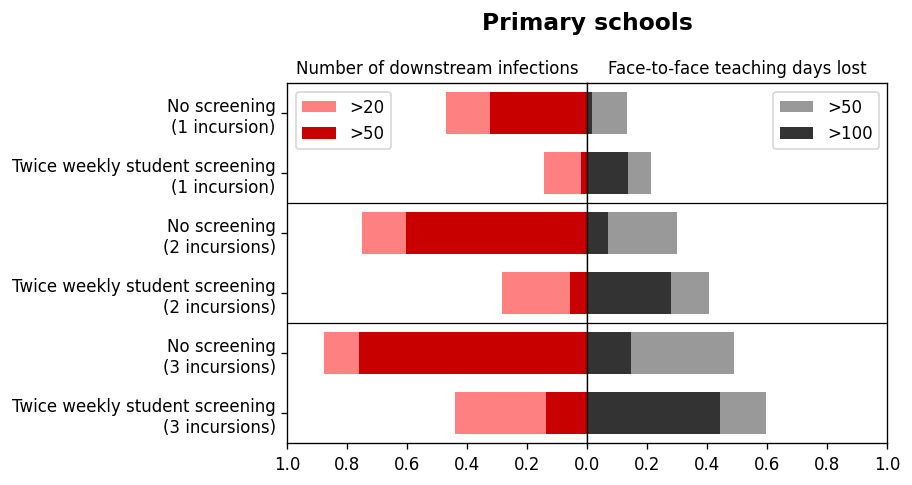

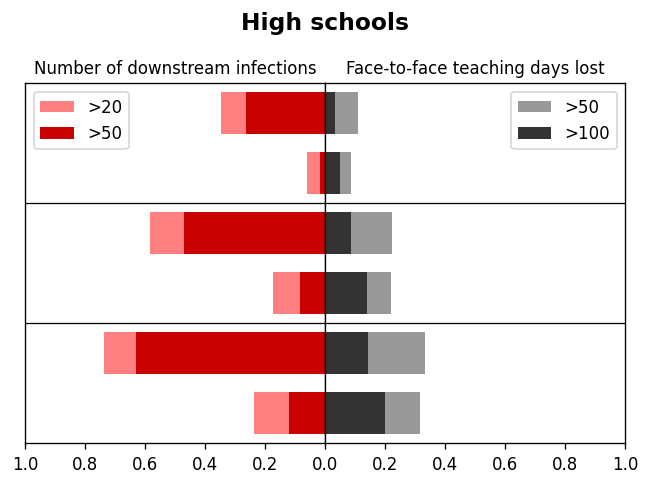

In [19]:
fig = plot_dual_bars(results = results.filter(
    n_incursions = [1,2,3],
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none','students'},
    tracing_algorithm='no_tracing',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: screening_desc[res.id['surveillance']] + f'\n({res.id["n_incursions"]} {"incursions" if res.id["n_incursions"] > 1 else "incursion"})',
    order = [5,4,3,2,1,0])
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

fig.axes[0].axhline(1.5, color='k', linewidth=0.75)
fig.axes[1].axhline(1.5, color='k', linewidth=0.75)
fig.axes[0].axhline(3.5, color='k', linewidth=0.75)
fig.axes[1].axhline(3.5, color='k', linewidth=0.75)

cvv.savefig('figures/sensitivity_incursions_notracing_ps.png')


fig = plot_dual_bars(results = results.filter(
    n_incursions = [1,2,3],
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none','students'},
    tracing_algorithm='no_tracing',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: screening_desc[res.id['surveillance']] + f'\n({res.id["n_incursions"]} {"incursions" if res.id["n_incursions"] > 1 else "incursion"})',
    order = [5,4,3,2,1,0],
)
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

fig.axes[0].yaxis.set_ticks([])

fig.axes[0].axhline(1.5, color='k', linewidth=0.75)
fig.axes[1].axhline(1.5, color='k', linewidth=0.75)
fig.axes[0].axhline(3.5, color='k', linewidth=0.75)
fig.axes[1].axhline(3.5, color='k', linewidth=0.75)

cvv.savefig('figures/sensitivity_incursions_notracing_hs.png')

## Sensitivity to vaccines

### Student vaccination

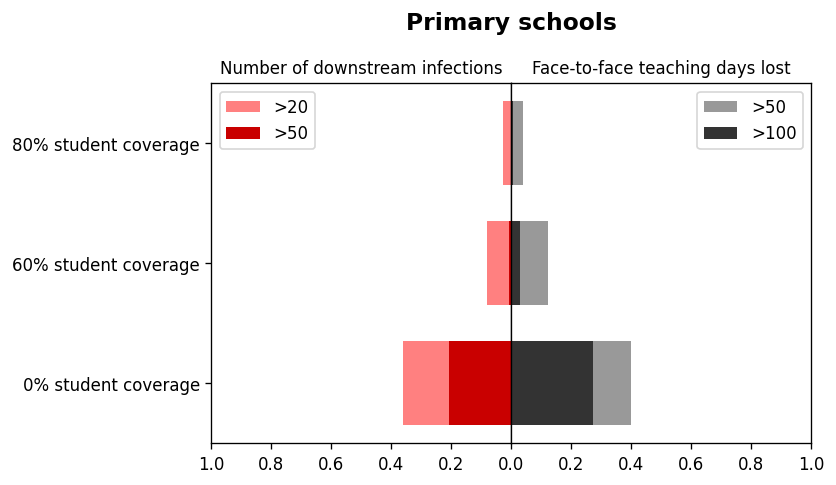

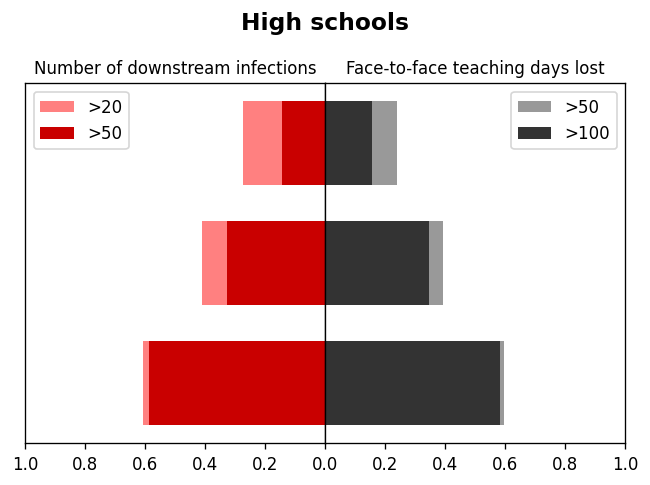

In [20]:
fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = {'0_80_80_80_100','60_80_80_80_100','80_80_80_80_100'},
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f"{res.id['vaccine_coverage'].split('_')[0]}% student coverage",
    )
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)

cvv.savefig('figures/sensitivity_vaccines_student_ps.png')

fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = {'0_0_0_80_100','0_60_60_80_100','0_80_80_80_100'},
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f"{res.id['vaccine_coverage'].split('_')[1]}% student coverage",
    order=[])
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)

fig.axes[0].yaxis.set_ticks([])

cvv.savefig('figures/sensitivity_vaccines_student_hs.png')


### Staff vaccination

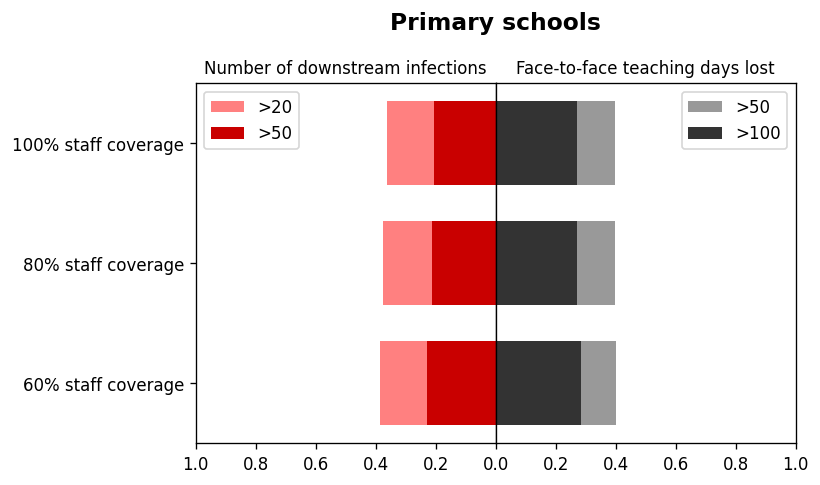

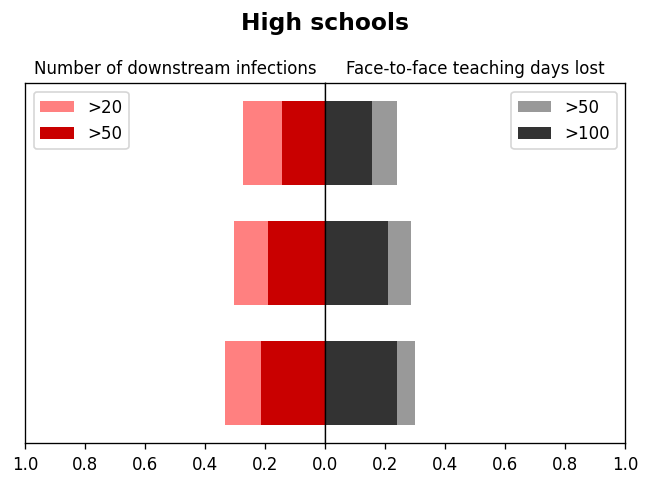

In [21]:
fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = {'0_80_80_80_100','0_80_80_80_80','0_80_80_80_60'},
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f"{res.id['vaccine_coverage'].split('_')[-1]}% staff coverage",
    order=[1,2,0],
                    )
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)

cvv.savefig('figures/sensitivity_vaccines_staff_ps.png')

fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = {'0_80_80_80_100','0_80_80_80_80','0_80_80_80_60'},
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f"{res.id['vaccine_coverage'].split('_')[-1]}% staff coverage",
    order=[1,2,0])
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)

fig.axes[0].yaxis.set_ticks([])

cvv.savefig('figures/sensitivity_vaccines_staff_hs.png')


## Sensitivity to NPIs

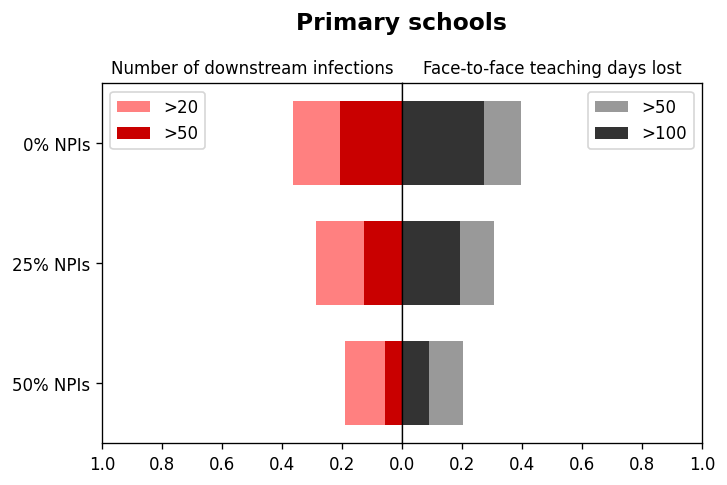

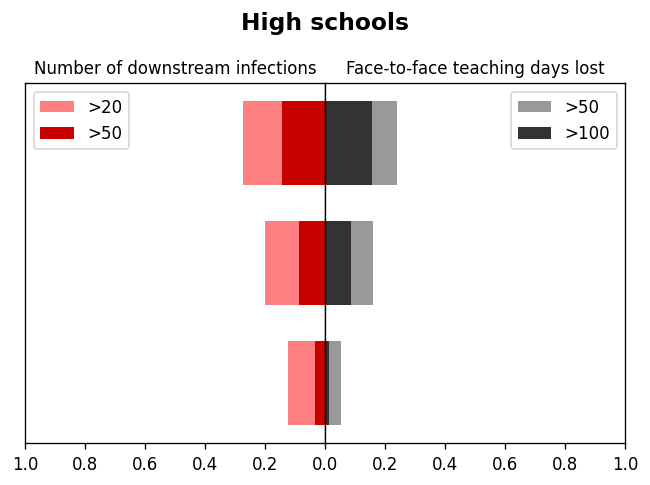

In [22]:
fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
#     npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f'{100*res.id["npis"]:.0f}% NPIs',
    order = [2,1,0])
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)

cvv.savefig('figures/sensitivity_npi_ps.png')


fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
#     npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f'{100*res.id["npis"]:.0f}% NPIs',
    order = [2,1,0])
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

fig.axes[0].yaxis.set_ticks([])

cvv.savefig('figures/sensitivity_npi_hs.png')



## Sensitivity to symptomatic test rate

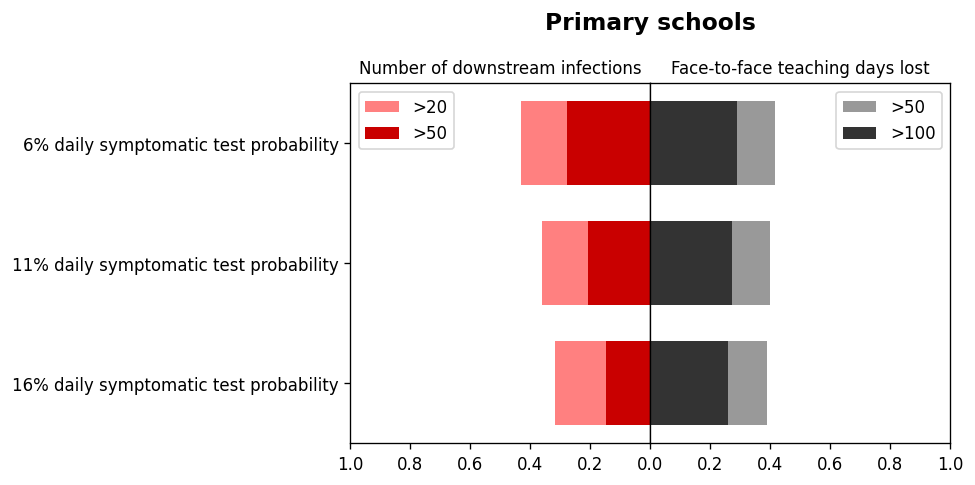

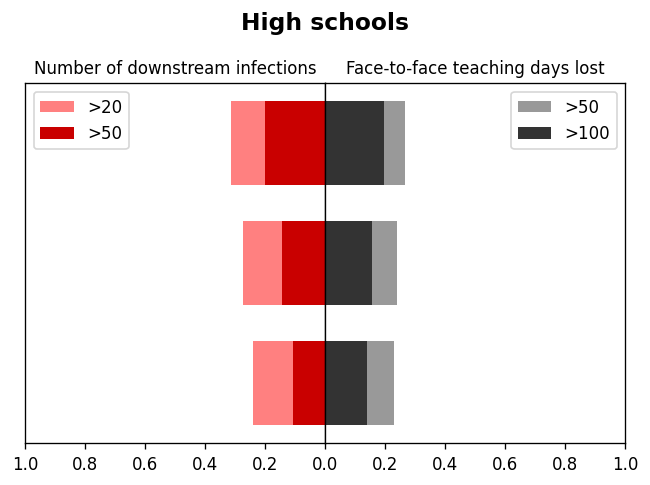

In [23]:
fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
#     symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f'{100*res.id["symp_prob"]:.0f}% daily symptomatic test probability',
    order = [2,1,0])
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)

cvv.savefig('figures/sensitivity_symp_prob_ps.png')

fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm='class_test_to_stay',
#     symp_prob=0.11,
    screening_frequency=2),
    label_fcn = lambda res: f'{100*res.id["symp_prob"]:.0f}% daily symptomatic test probability',
    order = [2,1,0],
                                         infection_thresholds=(21,51),
)
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

fig.axes[0].yaxis.set_ticks([])

cvv.savefig('figures/sensitivity_symp_prob_hs.png')



## Sensitivity to screening frequency

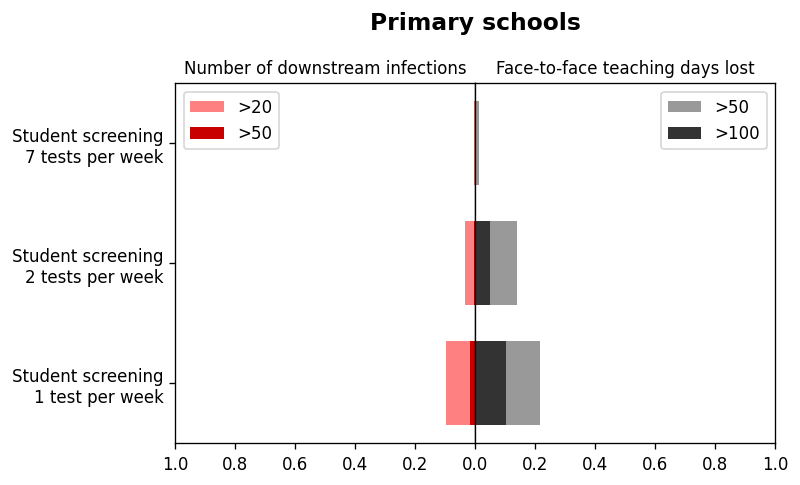

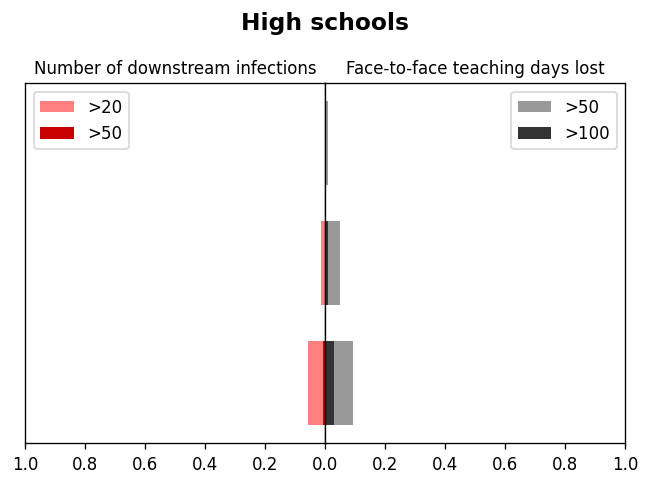

In [24]:
fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'students'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=[1,2,7],
),
    label_fcn = lambda res: f'Student screening\n{res.id["screening_frequency"]} test{"s" if res.id["screening_frequency"]>1 else ""} per week',
    order = [])
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)

cvv.savefig('figures/sensitivity_freq_ps.png')


fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
    cross_classroom = 'base',
    surveillance = {'students'},
    tracing_algorithm='class_test_to_stay',
    symp_prob=0.11,
    screening_frequency=[1,2,7],
),
    label_fcn = lambda res: f'Student screening\n{res.id["screening_frequency"]} test{"s" if res.id["screening_frequency"]>1 else ""} per week',
    order = [])
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)

fig.axes[0].yaxis.set_ticks([])

cvv.savefig('figures/sensitivity_freq_hs.png')



## Sensitivity to cross-classroom interactions

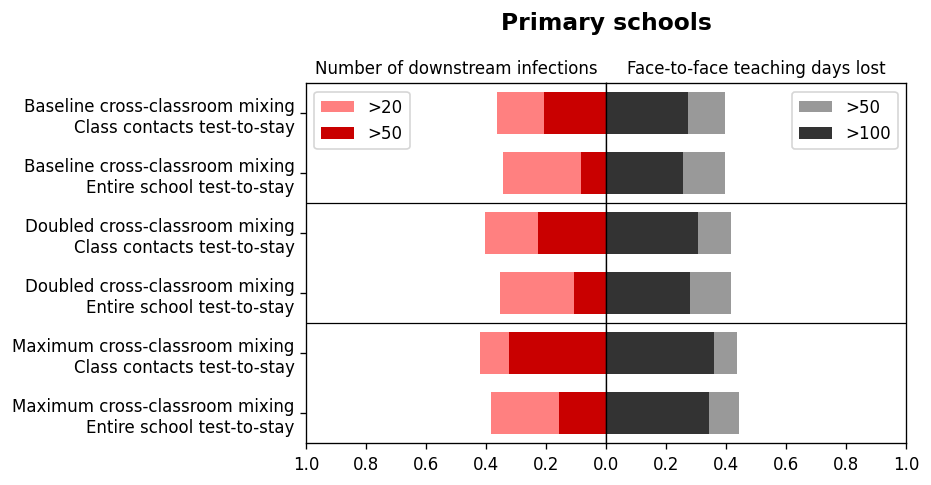

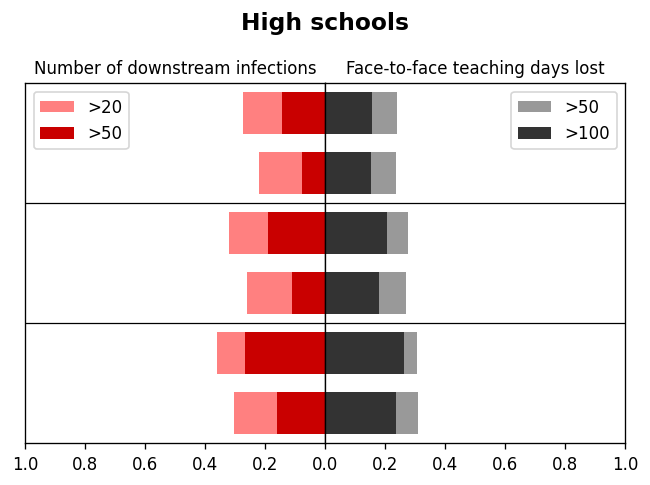

In [25]:
cross_desc = {
    'base':'Baseline cross-classroom mixing',
    'double':'Doubled cross-classroom mixing',
    'max':'Maximum cross-classroom mixing',
}
    
fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'primary_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
#     cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm=['class_test_to_stay','school_test_to_stay'],
    symp_prob=0.11,
    screening_frequency=2,
),
    label_fcn = lambda res: f'{cross_desc[res.id["cross_classroom"]]}' + '\n' + tracing_desc[res.id['tracing_algorithm']],
    order=[5,2,4,1,3,0],
                     infection_thresholds=(21,51),
                    )
fig.suptitle('Primary schools', fontsize=14, fontweight='bold', y=1.2)

fig.axes[0].axhline(1.5, color='k', linewidth=0.75)
fig.axes[1].axhline(1.5, color='k', linewidth=0.75)
fig.axes[0].axhline(3.5, color='k', linewidth=0.75)
fig.axes[1].axhline(3.5, color='k', linewidth=0.75)

cvv.savefig('figures/sensitivity_cross_class_ps.png')

fig = plot_dual_bars(results = results.filter(
    n_incursions = 1,
    incursion_layer = 'high_school',
    npis = 0,
    vaccine_coverage = '0_80_80_80_100',
    tts_compliance = 1,
#     cross_classroom = 'base',
    surveillance = {'none'},
    tracing_algorithm=['class_test_to_stay','school_test_to_stay'],
    symp_prob=0.11,
    screening_frequency=2,
),
    label_fcn = lambda res: f'{cross_desc[res.id["cross_classroom"]]}' + '\n' + tracing_desc[res.id['tracing_algorithm']],
    order=[5,2,4,1,3,0],
                     infection_thresholds=(21,51),
                    )
fig.suptitle('High schools', fontsize=14, fontweight='bold', y=1.2)
# fig.tight_layout()

fig.axes[0].yaxis.set_ticks([])

fig.axes[0].axhline(1.5, color='k', linewidth=0.75)
fig.axes[1].axhline(1.5, color='k', linewidth=0.75)
fig.axes[0].axhline(3.5, color='k', linewidth=0.75)
fig.axes[1].axhline(3.5, color='k', linewidth=0.75)

cvv.savefig('figures/sensitivity_cross_class_hs.png')
